## Plot AIWP output for cold front (using CIRA output)
### first download and subset using subset_cira_output.ipynb
#### (could eventually automate this via the s3 bucket)

In [4]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import metpy.calc as mpcalc
from metpy.units import units

from herbie import Herbie
import cdsapi
import fsspec

from fig_title import fig_title

import pickle
import os
from itertools import repeat
import string

### specify model name for plot titles, where your output files are, and where you want the images to go

In [21]:
init = pd.Timestamp(2022,12,19,0)

get_era5 = False  ### do we need to get ERA5 data (True) or do we already have it (False)?

leads_to_plot = range(66,90,6)

models_to_plot = ['fcn','pangu','gc',
                  #'ifs',
                  'gfs','era5']
                 # 'aifs','ifs']

model_names_dict = {"fcnv2":"Fourcastnet-v2-small", "fcnv2-hres":"Fourcastnet-v2-small","fcn":"Fourcastnet-v2-small",
                    "pangu":"Pangu-weather","pangu-hres":"Pangu-weather","pangu-cira":"Pangu-weather",
                    "aurora":"Aurora", "aurora-hres":"Aurora",
                    "graphcast": "Graphcast", "graphcast-hres": "Graphcast","gc": "Graphcast",
                    "aifs": "ECMWF AIFS",
                     "ifs": "ECMWF HRES (physics-based)",
                    "gfs": "GFS (physics-based)",
                    'era5': "ERA5"
                   }

imagedir = "aiwp_images"  ### where images will be written


### nice surface temperature colormap (optional)

In [8]:
### temperature from pickle
fp = open('sfc_temp_cmap.pkl', 'rb')
sfc_temp_cmap = pickle.load(fp)
fp.close()


## make some maps!

### setup

In [27]:
datacrs = ccrs.PlateCarree()

plotcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=37.5)

def plot_background(ax):
    ### set up bounding box surrounding specified station
    #latmin=27.75
    #latmax=48.25
    #lonmin=-118.7
    #lonmax=-83.75

    latmin = 32.
    #latmin=34.75
    latmax=45.
    lonmin=-110.7
    lonmax=-95.75

    ax.set_extent([lonmin,lonmax,latmin,latmax])
    ax.coastlines('50m', edgecolor='black', linewidth=0.8)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.9)

    return lonmin,lonmax,latmin,latmax

### 2-m temperature

lead: 66
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F66 ┊ GRIB2 @ aws ┊ IDX @ aws
era5


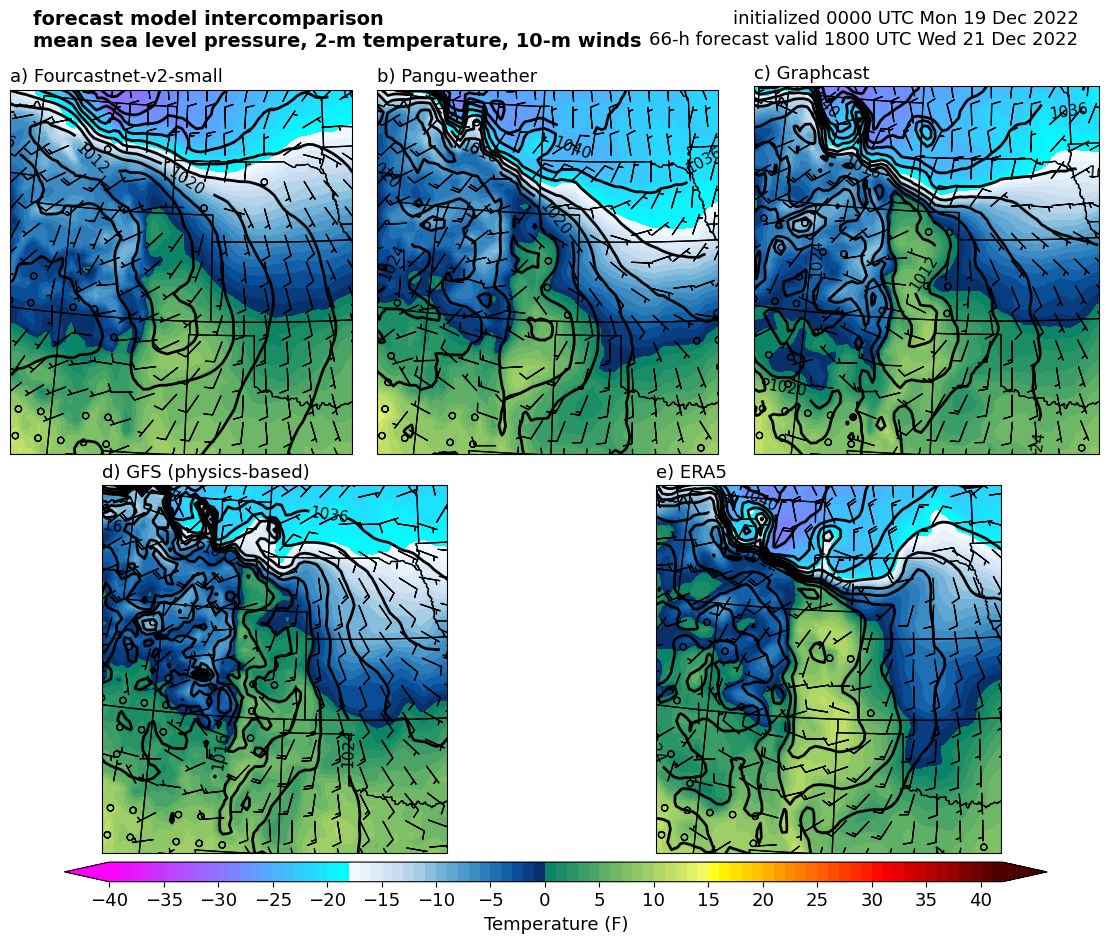

lead: 72
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws
era5


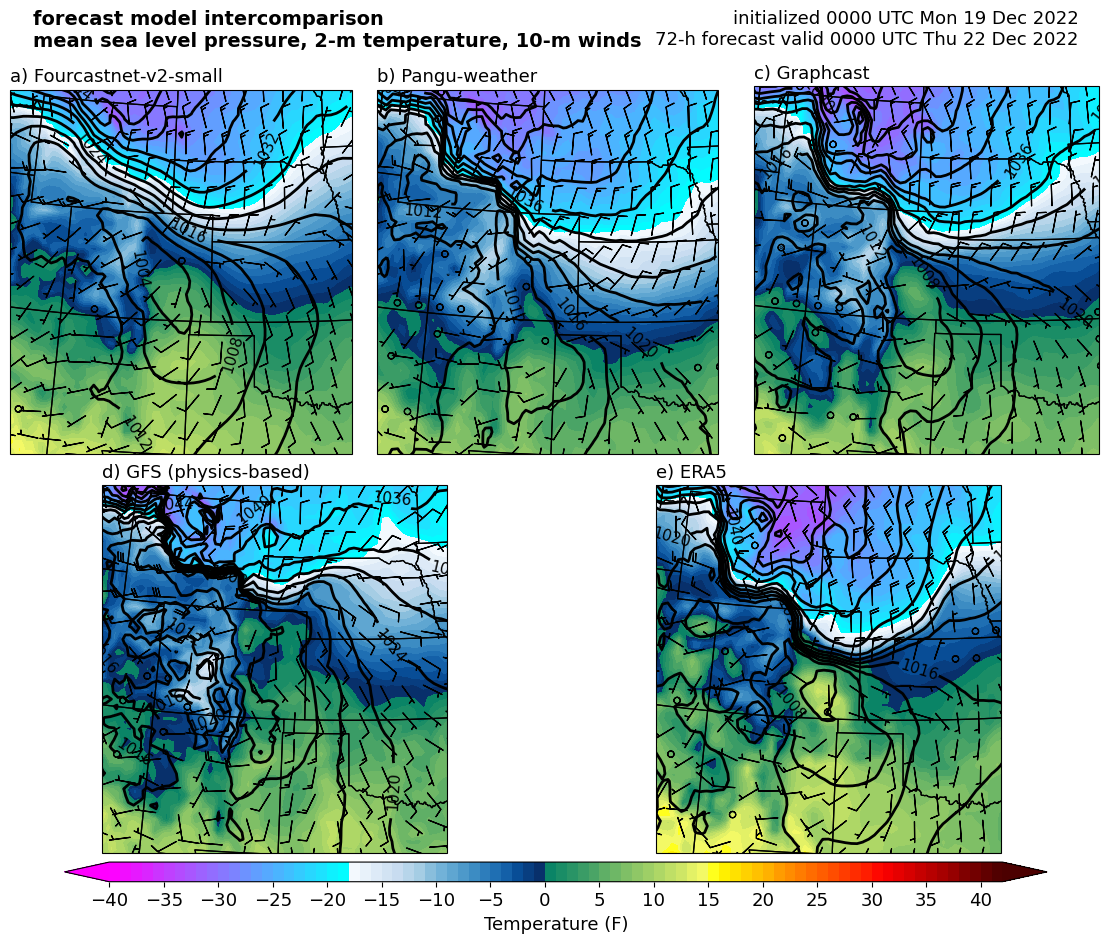

lead: 78
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F78 ┊ GRIB2 @ aws ┊ IDX @ aws
era5


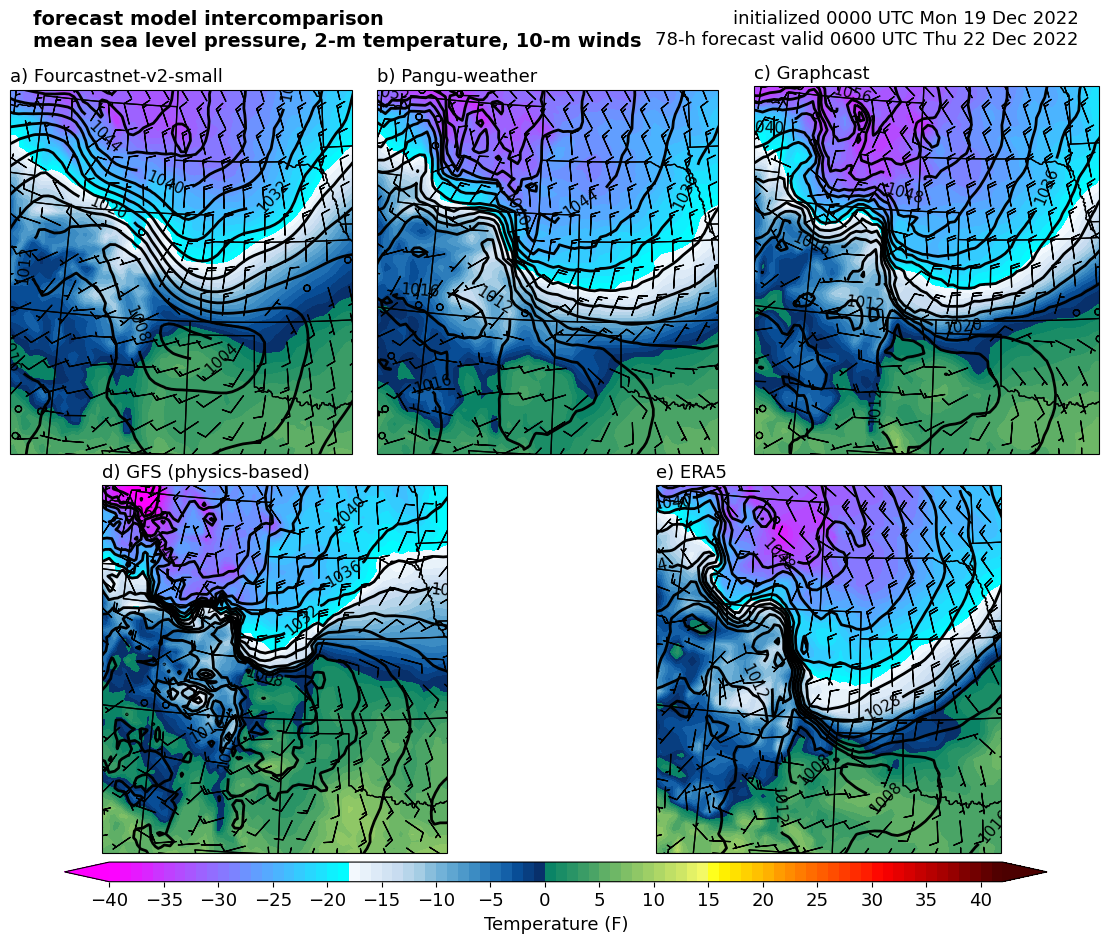

lead: 84
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F84 ┊ GRIB2 @ aws ┊ IDX @ aws
era5


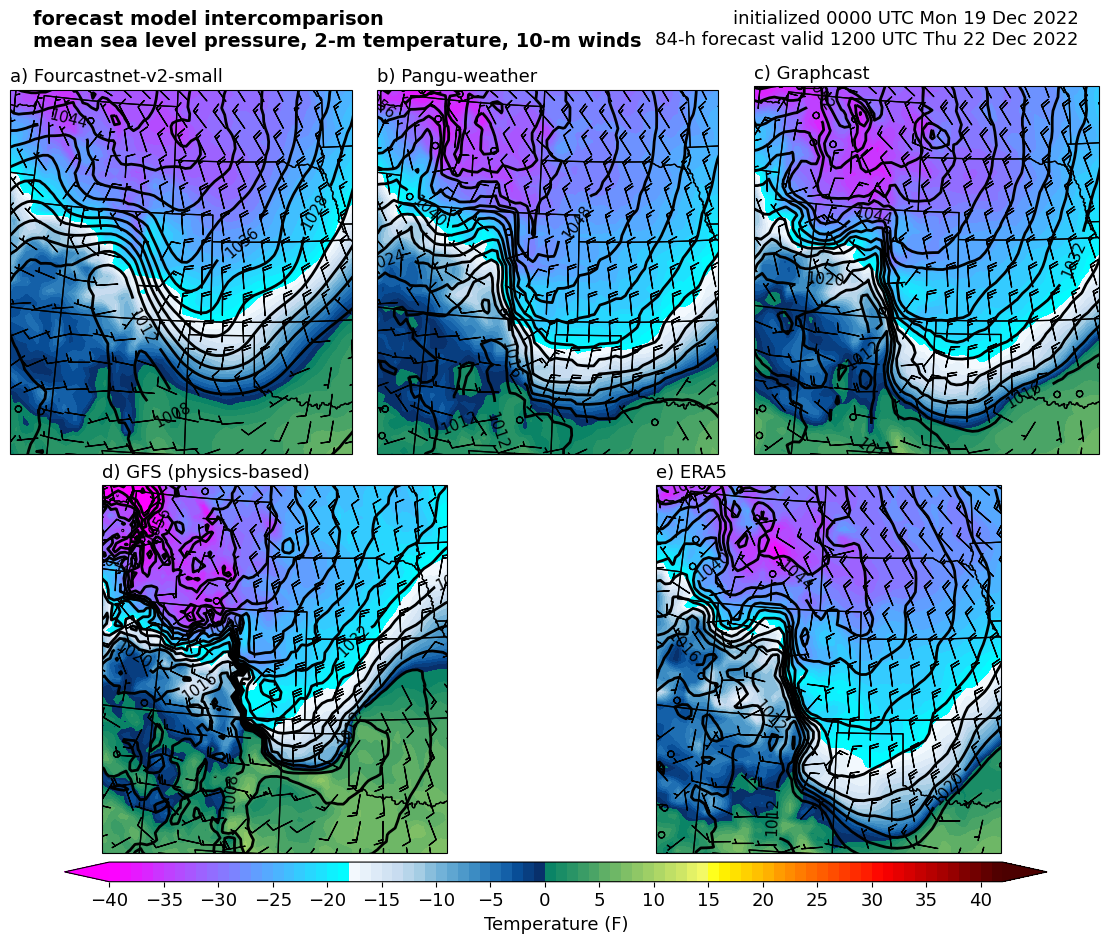

In [36]:
clevs = np.arange(-40, 43, 1)

#fcst_lead = 24
#for fcst_lead in range(0,78,6):
for fcst_lead in leads_to_plot:

    idx = 0

    print("lead: "+str(fcst_lead))

    fig = plt.figure(layout="constrained", figsize=(11,9))

    valid_time = init + pd.Timedelta(hours=fcst_lead)
    
    axlist=[]
    ax_dict = fig.subplot_mosaic(
        [
            #models_to_plot[0:3],
            #models_to_plot[3:6],
            [x for item in models_to_plot[0:3] for x in repeat(item, 2)],
            [x for item in models_to_plot[3:5] for x in repeat(item, 3)]
        ],
        subplot_kw={"projection": plotcrs})
    
    for k, ax in ax_dict.items():
        lonmin, lonmax, latmin, latmax = plot_background(ax)
        axlist = axlist + [ax]
    
    ### read in data, looping over models
    for model in models_to_plot:
    
        print(model)

        #try:
        if model in ['fcnv2-hres','pangu-hres','aurora-hres','graphcast-hres','fcnv2','aurora','graphcast']:
           
            ds_10m = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='',
                                    filter_by_keys={'typeOfLevel': 'heightAboveGround', 'level':10})
            ds_2m = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='',
                                    filter_by_keys={'typeOfLevel': 'heightAboveGround', 'level':2})
            ds_msl = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='',
                                    filter_by_keys={'typeOfLevel': 'meanSea'})
        elif model in ['ifs','aifs']:
            H = Herbie(init.strftime("%Y-%m-%d %H:%M"), model=model, product="oper", fxx=fcst_lead)
            ds_msl = H.xarray(":msl:")
            ds_10m =  H.xarray(":10[u|v]:")
            ds_2m =  H.xarray(":2t:")
        elif model in ['gfs','gfs-graphcast']:
            H = Herbie(init.strftime("%Y-%m-%d %H:%M"), model=model, fxx=fcst_lead)
            ds_msl = H.xarray(":mean sea level:", remove_grib=False).rename({'prmsl':'msl'})
            ds_10m =  H.xarray(":10 m above ground:", remove_grib=False)
            ds_2m =  H.xarray(":2 m above ground:", remove_grib=False)
        elif model in ['pangu','fcn','gc']:
            ds_msl = xr.open_dataset("cira_ai_output/"+model+"_msl_subset_"+init.strftime("%Y%m%d%H")+".nc").sel(time=valid_time)['msl'].to_dataset()
            vars_10m = ['u10','v10']
            ds_10m = xr.open_dataset("cira_ai_output/"+model+"_10m_subset_"+init.strftime("%Y%m%d%H")+".nc").sel(time=valid_time)[vars_10m]
            ds_2m = xr.open_dataset("cira_ai_output/"+model+"_t2_subset_"+init.strftime("%Y%m%d%H")+".nc").sel(time=valid_time)['t2'].to_dataset()
            ds_2m = ds_2m.rename({'t2':'t2m'})
        elif model in ['era5']:
        ### get era5 data for this time (try lazy loading)
            if get_era5:
            
                URL = 'https://cds.climate.copernicus.eu/api'
                KEY = '952952fc-3d88-4656-86b3-17c13a7c581c'
                
                client = cdsapi.Client(url=URL, key=KEY)
    
                dataset = "reanalysis-era5-single-levels"
                request = {
                  'product_type': ['reanalysis'],
                    'variable': ['mean_sea_level_pressure',
                                 '10m_u_component_of_wind', '10m_v_component_of_wind',
                                 '2m_temperature', ],
                  'year': [valid_time.strftime("%Y")],
                  'month': [valid_time.strftime("%m")],
                  'day': [valid_time.strftime("%d")],
                  'time': [valid_time.strftime("%H:%M")],
                }
    
                client.retrieve(dataset, request,
                               "/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib")

            vars_10m = ['u10','v10']
            ds_10m = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='')[vars_10m]
            ds_2m = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='')['t2m'].to_dataset()
            ds_msl = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='')['msl'].to_dataset()
            
        ### subset data
        if ds_msl.longitude.min().item() >= -10:
            ds_msl = ds_msl.sel(longitude=slice(lonmin+360-5, lonmax+360+5), latitude=slice(latmax+5,latmin-5))
            ds_10m = ds_10m.sel(longitude=slice(lonmin+360-5, lonmax+360+5), latitude=slice(latmax+5,latmin-5))
            ds_2m = ds_2m.sel(longitude=slice(lonmin+360-5, lonmax+360+5), latitude=slice(latmax+5,latmin-5))
        else:
            ds_msl = ds_msl.sel(longitude=slice(lonmin-5, lonmax+5), latitude=slice(latmax+5,latmin-5))
            ds_10m = ds_10m.sel(longitude=slice(lonmin-5, lonmax+5), latitude=slice(latmax+5,latmin-5))
            ds_2m = ds_2m.sel(longitude=slice(lonmin-5, lonmax+5), latitude=slice(latmax+5,latmin-5))
            
        ### now make the plot! 
        lon2d, lat2d = np.meshgrid(ds_msl.longitude, ds_msl.latitude)

        ### MSLP
        cs1 = ax_dict[model].contour(lon2d, lat2d,
                         ds_msl.msl/100.,
                                np.arange(900,1100,4), colors='black',
                                     linewidths=2, transform=ccrs.PlateCarree(),
                         transform_first=True)
        plt.clabel(cs1, fontsize=11, inline=True, inline_spacing=5, fmt='%i',
                            rightside_up=True, use_clabeltext=True)
        
        ### 2-m temp
        cf = ax_dict[model].contourf(lon2d, lat2d, ds_2m.t2m-273.15,
                             clevs,
                             cmap=sfc_temp_cmap, extend='both',
                             transform=ccrs.PlateCarree(), transform_first=True)
        #cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, shrink=0.6)
        #cb.set_label('Temperature (F)', fontsize=10)
        #cb.ax.tick_params(labelsize=10)
        #cb.ax.locator_params(nbins=20)
    
        ### winds
        # Transform Vectors before plotting, then plot wind barbs.
        wind_slice = (slice(None, None, 4), slice(None, None, 4))
        ax_dict[model].barbs(ds_10m.u10[wind_slice].longitude, ds_10m.u10[wind_slice].latitude,
                 ds_10m.u10[wind_slice].values*1.943844, ds_10m.v10[wind_slice].values*1.943844,   ### to knots
                 lw=0.9, length=5.5,
                 transform=ccrs.PlateCarree())
   
        ax_dict[model].set_title(string.ascii_lowercase[idx]+") "+model_names_dict[model], fontsize=13,
                                loc='left')

        idx = idx + 1

   # except:
   #     pass

    ### overall colorbar
    cb = plt.colorbar(cf, ax=axlist, orientation='horizontal', pad=0.01,
                      shrink=0.9, aspect=50)
    cb.ax.tick_params(labelsize=13)
    cb.set_label('Temperature (F)', fontsize=13)
    cb.ax.locator_params(nbins=20)  
    
    ### uses "fig_title" function to make multiple suptitles...
    fig_title(fig, "forecast model intercomparison\nmean sea level pressure, 2-m temperature, 10-m winds",
              loc="left", horizontalalignment='left', fontsize=14, fontweight='bold')
    fig_title(fig, "initialized "+init.strftime("%H%M UTC %a %d %b %Y")+"\n"+str(fcst_lead)+"-h forecast valid "+valid_time.strftime("%H%M UTC %a %d %b %Y"),
              loc="right", horizontalalignment='right', fontsize=13)
    
    outdir = imagedir+"/"+init.strftime("%Y%m%d%H")
    os.system("mkdir -p "+outdir)
    
    outfile = "t2m_compare_cira_"+init.strftime("%Y%m%d%H")+"_f"+str(fcst_lead).zfill(3)+".png"
    
    plt.savefig(outdir+"/"+outfile,
                bbox_inches='tight', transparent=False, facecolor='white', dpi=225)
    
    plt.show()

### 2-m temperature gradient

lead: 66
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F66 ┊ GRIB2 @ aws ┊ IDX @ aws


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/1518316529.py:70: UserWarning: More than one time coordinate present for variable  "t2m".
  t2m_grad_x = mpcalc.geospatial_gradient(ds_2m.t2m)[0]


era5


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/1518316529.py:70: UserWarning: More than one time coordinate present for variable  "t2m".
  t2m_grad_x = mpcalc.geospatial_gradient(ds_2m.t2m)[0]


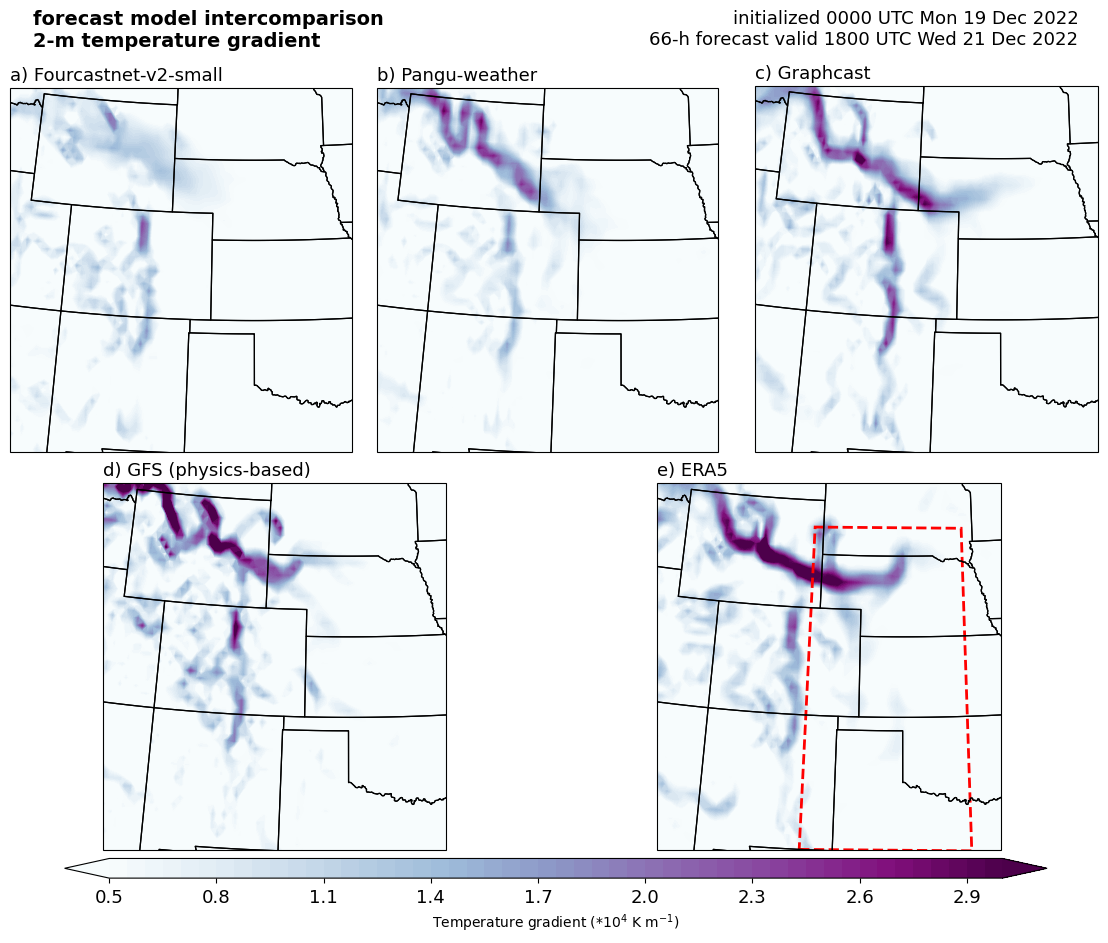

lead: 72
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/1518316529.py:70: UserWarning: More than one time coordinate present for variable  "t2m".
  t2m_grad_x = mpcalc.geospatial_gradient(ds_2m.t2m)[0]


era5


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/1518316529.py:70: UserWarning: More than one time coordinate present for variable  "t2m".
  t2m_grad_x = mpcalc.geospatial_gradient(ds_2m.t2m)[0]


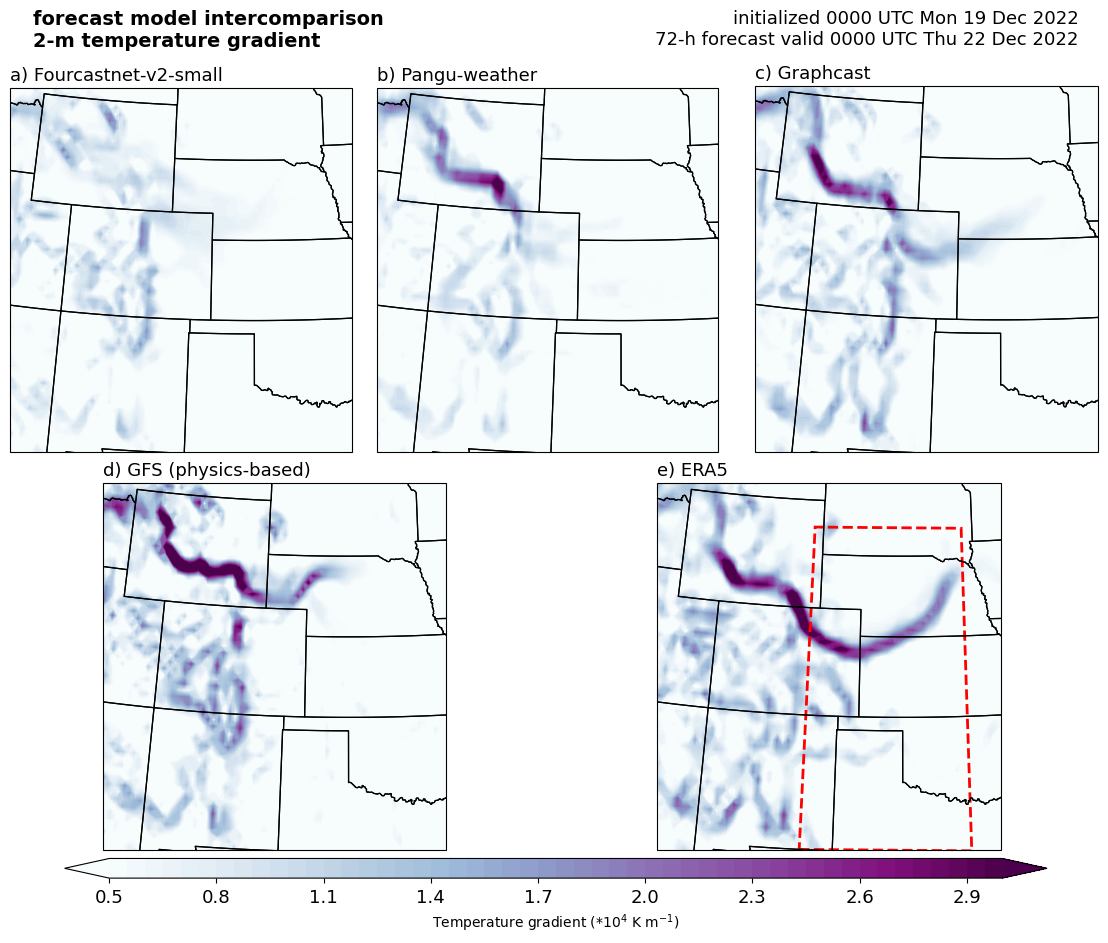

lead: 78
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F78 ┊ GRIB2 @ aws ┊ IDX @ aws


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/1518316529.py:70: UserWarning: More than one time coordinate present for variable  "t2m".
  t2m_grad_x = mpcalc.geospatial_gradient(ds_2m.t2m)[0]


era5


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/1518316529.py:70: UserWarning: More than one time coordinate present for variable  "t2m".
  t2m_grad_x = mpcalc.geospatial_gradient(ds_2m.t2m)[0]


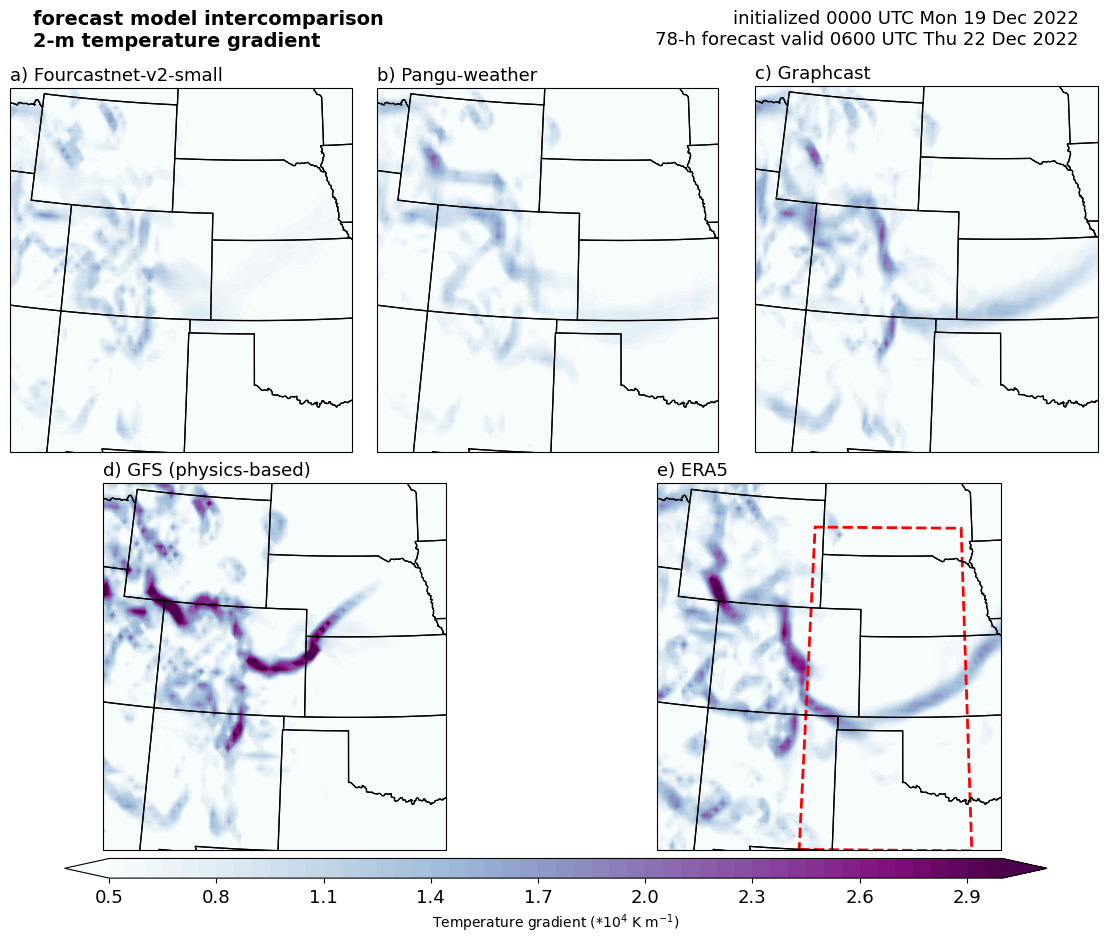

lead: 84
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F84 ┊ GRIB2 @ aws ┊ IDX @ aws


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/1518316529.py:70: UserWarning: More than one time coordinate present for variable  "t2m".
  t2m_grad_x = mpcalc.geospatial_gradient(ds_2m.t2m)[0]


era5


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/1518316529.py:70: UserWarning: More than one time coordinate present for variable  "t2m".
  t2m_grad_x = mpcalc.geospatial_gradient(ds_2m.t2m)[0]


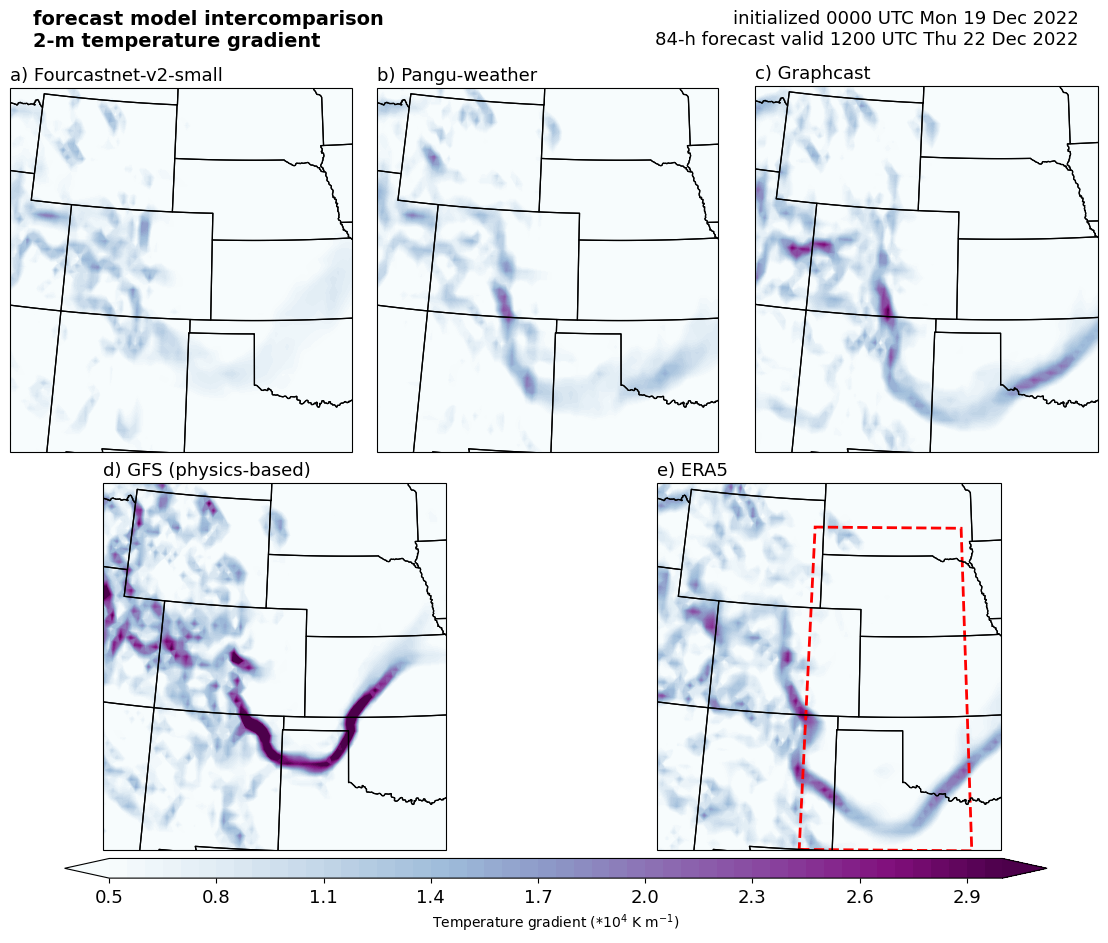

In [37]:
#fcst_lead = 24
#for fcst_lead in range(0,78,6):
for fcst_lead in leads_to_plot:

    idx = 0

    print("lead: "+str(fcst_lead))

    fig = plt.figure(layout="constrained", figsize=(11,9))

    valid_time = init + pd.Timedelta(hours=fcst_lead)
    
    axlist=[]
    ax_dict = fig.subplot_mosaic(
        [
            #models_to_plot[0:3],
            #models_to_plot[3:6],
            [x for item in models_to_plot[0:3] for x in repeat(item, 2)],
            [x for item in models_to_plot[3:5] for x in repeat(item, 3)]
        ],
        subplot_kw={"projection": plotcrs})
    
    for k, ax in ax_dict.items():
        lonmin, lonmax, latmin, latmax = plot_background(ax)
        axlist = axlist + [ax]
    
    ### read in data, looping over models
    for model in models_to_plot:
    
        print(model)

        #try:
        if model in ['fcnv2-hres','pangu-hres','aurora-hres','graphcast-hres','fcnv2','aurora','graphcast']:
           
            ds_2m = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='',
                                    filter_by_keys={'typeOfLevel': 'heightAboveGround', 'level':2})
            #ds_msl = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
            #                         indexpath='',
            #                        filter_by_keys={'typeOfLevel': 'meanSea'})
        elif model in ['ifs','aifs']:
            H = Herbie(init.strftime("%Y-%m-%d %H:%M"), model=model, product="oper", fxx=fcst_lead)
            #ds_msl = H.xarray(":msl:", remove_grib=False)
            ds_2m =  H.xarray(":2t:", remove_grib=False)
        elif model in ['gfs','gfs-graphcast']:
            H = Herbie(init.strftime("%Y-%m-%d %H:%M"), model=model, fxx=fcst_lead)
            #ds_msl = H.xarray(":mean sea level:", remove_grib=False).rename({'prmsl':'msl'})
            ds_2m =  H.xarray(":2 m above ground:", remove_grib=False)
        elif model in ['pangu','fcn','gc']:
            #ds_msl = xr.open_dataset("cira_ai_output/"+model+"_msl_subset_"+init.strftime("%Y%m%d%H")+".nc").sel(time=valid_time)['msl'].to_dataset()
            ds_2m = xr.open_dataset("cira_ai_output/"+model+"_t2_subset_"+init.strftime("%Y%m%d%H")+".nc").sel(time=valid_time)['t2'].to_dataset()
            ds_2m = ds_2m.rename({'t2':'t2m'})
        elif model in ['era5']:
            ds_2m = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='')['t2m'].to_dataset()
            #ds_msl = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
            #                         indexpath='')['msl'].to_dataset()
            
        ### subset data
        if ds_2m.longitude.min().item() >= -10:
           # ds_msl = ds_msl.sel(longitude=slice(lonmin+360-5, lonmax+360+5), latitude=slice(latmax+5,latmin-5))
           # ds_10m = ds_10m.sel(longitude=slice(lonmin+360-5, lonmax+360+5), latitude=slice(latmax+5,latmin-5))
            ds_2m = ds_2m.sel(longitude=slice(lonmin+360-5, lonmax+360+5), latitude=slice(latmax+5,latmin-5))
        else:
           # ds_msl = ds_msl.sel(longitude=slice(lonmin-5, lonmax+5), latitude=slice(latmax+5,latmin-5))
           # ds_10m = ds_10m.sel(longitude=slice(lonmin-5, lonmax+5), latitude=slice(latmax+5,latmin-5))
            ds_2m = ds_2m.sel(longitude=slice(lonmin-5, lonmax+5), latitude=slice(latmax+5,latmin-5))

        ### calculate gradients
        t2m_grad_x = mpcalc.geospatial_gradient(ds_2m.t2m)[0]
        t2m_grad_y = mpcalc.geospatial_gradient(ds_2m.t2m)[1]

        clevs = np.arange(0.5,3.05,0.05)  ### range of temperatures

        ### now make the plot! 
        lon2d, lat2d = np.meshgrid(ds_2m.longitude, ds_2m.latitude)

        ### MSLP
        #cs1 = ax_dict[model].contour(lon2d, lat2d,
        #                 ds_msl.msl/100.,
        #                        np.arange(900,1100,4), colors='black',
        #                             linewidths=2, transform=ccrs.PlateCarree(),
        #                 transform_first=True)
        #plt.clabel(cs1, fontsize=11, inline=True, inline_spacing=5, fmt='%i',
        #                    rightside_up=True, use_clabeltext=True)
        
        ### 2-m temp
        cf = ax_dict[model].contourf(lon2d, lat2d, 1e4*((t2m_grad_x**2 + t2m_grad_y**2)**0.5),
                             clevs,
                             cmap="BuPu", extend='both',
                             transform=ccrs.PlateCarree(), transform_first=True)

        ax_dict[model].set_title(string.ascii_lowercase[idx]+") "+model_names_dict[model], fontsize=13,
                                loc='left')

        ### add FSS analysis box
        if model=="era5":
            ax_dict[model].add_patch(mpatches.Rectangle(xy=[-104.5, 32.], width=7.5, height=12.,
                                fill=False, edgecolor='red', linestyle='dashed',
                                linewidth=2, 
                                transform=ccrs.PlateCarree())
             )
        

        idx = idx + 1
        
   # except:
   #     pass

    ### overall colorbar
    cb = plt.colorbar(cf, ax=axlist, orientation='horizontal', pad=0.01,
                      shrink=0.9, aspect=50)
    cb.ax.tick_params(labelsize=13)
    cb.set_label('Temperature gradient ($*10^4$ K m$^{-1}$)', fontsize=10)

    
    ### uses "fig_title" function to make multiple suptitles...
    fig_title(fig, "forecast model intercomparison\n2-m temperature gradient",
              loc="left", horizontalalignment='left', fontsize=14, fontweight='bold')
    fig_title(fig, "initialized "+init.strftime("%H%M UTC %a %d %b %Y")+"\n"+str(fcst_lead)+"-h forecast valid "+valid_time.strftime("%H%M UTC %a %d %b %Y"),
              loc="right", horizontalalignment='right', fontsize=13)
    
    outdir = imagedir+"/"+init.strftime("%Y%m%d%H")
    os.system("mkdir -p "+outdir)
    
    outfile = "t2m_grad_compare_cira_"+init.strftime("%Y%m%d%H")+"_f"+str(fcst_lead).zfill(3)+".png"
    
    plt.savefig(outdir+"/"+outfile,
                bbox_inches='tight', transparent=False, facecolor='white', dpi=225)
    
    plt.show()

### MSLP gradient

lead: 66
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F66 ┊ GRIB2 @ aws ┊ IDX @ aws


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/3043920278.py:70: UserWarning: More than one time coordinate present for variable  "msl".
  mslp_grad_x = mpcalc.geospatial_gradient(ds_msl.msl)[0]


era5


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/3043920278.py:70: UserWarning: More than one time coordinate present for variable  "msl".
  mslp_grad_x = mpcalc.geospatial_gradient(ds_msl.msl)[0]


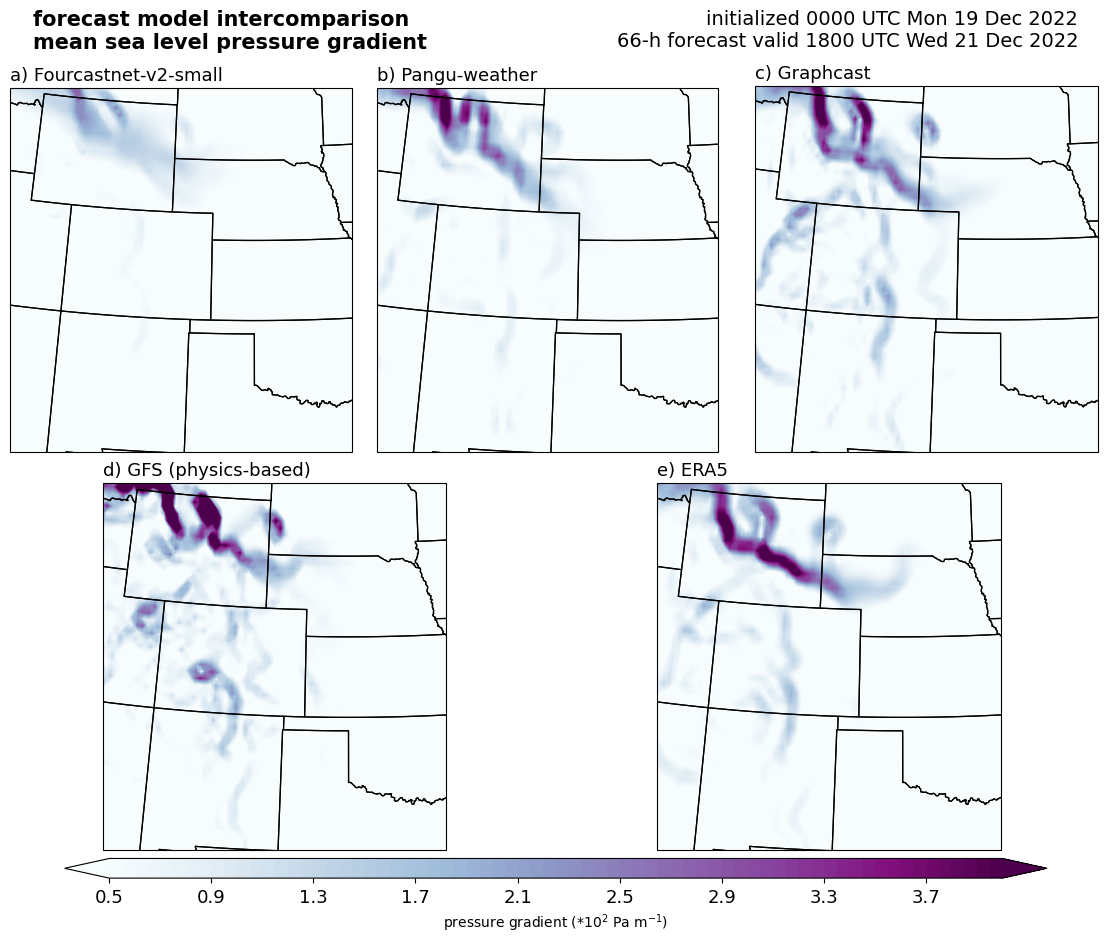

lead: 72
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/3043920278.py:70: UserWarning: More than one time coordinate present for variable  "msl".
  mslp_grad_x = mpcalc.geospatial_gradient(ds_msl.msl)[0]


era5


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/3043920278.py:70: UserWarning: More than one time coordinate present for variable  "msl".
  mslp_grad_x = mpcalc.geospatial_gradient(ds_msl.msl)[0]


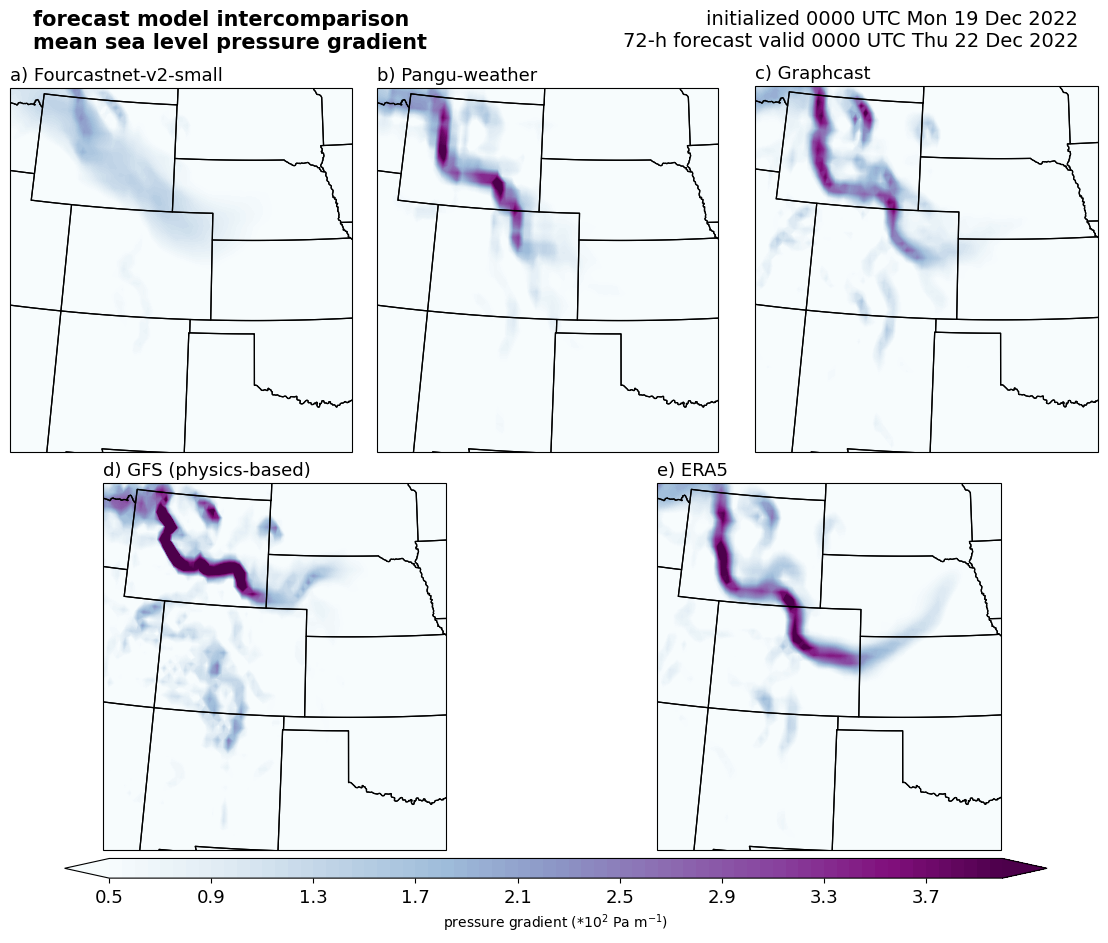

lead: 78
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F78 ┊ GRIB2 @ aws ┊ IDX @ aws


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/3043920278.py:70: UserWarning: More than one time coordinate present for variable  "msl".
  mslp_grad_x = mpcalc.geospatial_gradient(ds_msl.msl)[0]


era5


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/3043920278.py:70: UserWarning: More than one time coordinate present for variable  "msl".
  mslp_grad_x = mpcalc.geospatial_gradient(ds_msl.msl)[0]


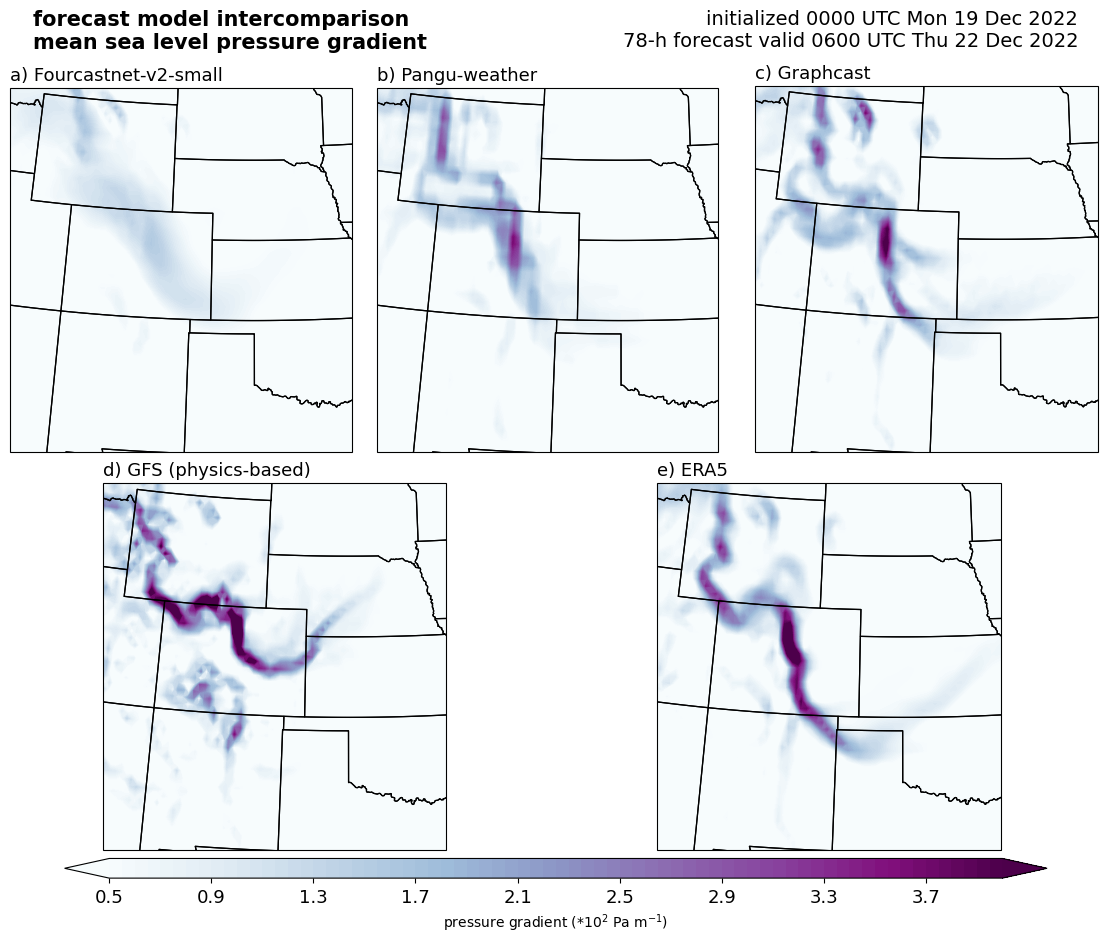

lead: 84
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F84 ┊ GRIB2 @ aws ┊ IDX @ aws


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/3043920278.py:70: UserWarning: More than one time coordinate present for variable  "msl".
  mslp_grad_x = mpcalc.geospatial_gradient(ds_msl.msl)[0]


era5


/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_7784/3043920278.py:70: UserWarning: More than one time coordinate present for variable  "msl".
  mslp_grad_x = mpcalc.geospatial_gradient(ds_msl.msl)[0]


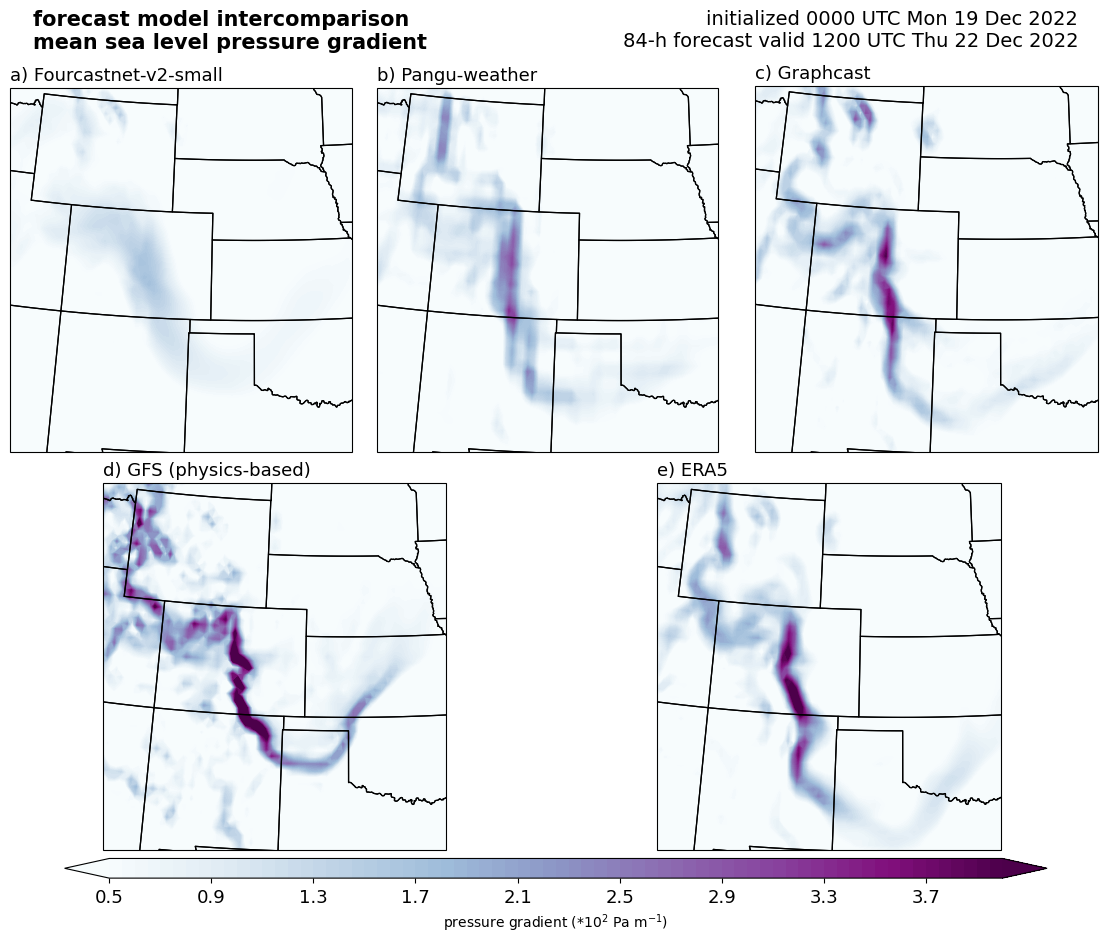

In [34]:

#fcst_lead = 24
#for fcst_lead in range(0,78,6):
for fcst_lead in leads_to_plot:

    idx = 0

    print("lead: "+str(fcst_lead))

    fig = plt.figure(layout="constrained", figsize=(11,9))

    valid_time = init + pd.Timedelta(hours=fcst_lead)
    
    axlist=[]
    ax_dict = fig.subplot_mosaic(
        [
            #models_to_plot[0:3],
            #models_to_plot[3:6],
            [x for item in models_to_plot[0:3] for x in repeat(item, 2)],
            [x for item in models_to_plot[3:5] for x in repeat(item, 3)]
        ],
        subplot_kw={"projection": plotcrs})
    
    for k, ax in ax_dict.items():
        lonmin, lonmax, latmin, latmax = plot_background(ax)
        axlist = axlist + [ax]
    
    ### read in data, looping over models
    for model in models_to_plot:
    
        print(model)

        #try:
        if model in ['fcnv2-hres','pangu-hres','aurora-hres','graphcast-hres','fcnv2','aurora','graphcast']:
           
            ds_2m = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='',
                                    filter_by_keys={'typeOfLevel': 'heightAboveGround', 'level':2})
            ds_msl = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='',
                                    filter_by_keys={'typeOfLevel': 'meanSea'})
        elif model in ['ifs','aifs']:
            H = Herbie(init.strftime("%Y-%m-%d %H:%M"), model=model, product="oper", fxx=fcst_lead)
            ds_msl = H.xarray(":msl:", remove_grib=False)
            ds_2m =  H.xarray(":2t:", remove_grib=False)
        elif model in ['gfs','gfs-graphcast']:
            H = Herbie(init.strftime("%Y-%m-%d %H:%M"), model=model, fxx=fcst_lead)
            ds_msl = H.xarray(":mean sea level:", remove_grib=False).rename({'prmsl':'msl'})
            ds_2m =  H.xarray(":2 m above ground:", remove_grib=False)
        elif model in ['pangu','fcn','gc']:
            ds_msl = xr.open_dataset("cira_ai_output/"+model+"_msl_subset_"+init.strftime("%Y%m%d%H")+".nc").sel(time=valid_time)['msl'].to_dataset()
            ds_2m = xr.open_dataset("cira_ai_output/"+model+"_t2_subset_"+init.strftime("%Y%m%d%H")+".nc").sel(time=valid_time)['t2'].to_dataset()
            ds_2m = ds_2m.rename({'t2':'t2m'})
        elif model in ['era5']:
            ds_2m = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='')['t2m'].to_dataset()
            ds_msl = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='')['msl'].to_dataset()
            
        ### subset data
        if ds_msl.longitude.min().item() >= -10:
            ds_msl = ds_msl.sel(longitude=slice(lonmin+360-5, lonmax+360+5), latitude=slice(latmax+5,latmin-5))
            ds_10m = ds_10m.sel(longitude=slice(lonmin+360-5, lonmax+360+5), latitude=slice(latmax+5,latmin-5))
            ds_2m = ds_2m.sel(longitude=slice(lonmin+360-5, lonmax+360+5), latitude=slice(latmax+5,latmin-5))
        else:
            ds_msl = ds_msl.sel(longitude=slice(lonmin-5, lonmax+5), latitude=slice(latmax+5,latmin-5))
            ds_10m = ds_10m.sel(longitude=slice(lonmin-5, lonmax+5), latitude=slice(latmax+5,latmin-5))
            ds_2m = ds_2m.sel(longitude=slice(lonmin-5, lonmax+5), latitude=slice(latmax+5,latmin-5))

        ### calculate gradients
        mslp_grad_x = mpcalc.geospatial_gradient(ds_msl.msl)[0]
        mslp_grad_y = mpcalc.geospatial_gradient(ds_msl.msl)[1]

        clevs = np.arange(0.5,4.05,0.05)  ### range of temperatures

        ### now make the plot! 
        lon2d, lat2d = np.meshgrid(ds_msl.longitude, ds_msl.latitude)

        ### MSLP
        #cs1 = ax_dict[model].contour(lon2d, lat2d,
        #                 ds_msl.msl/100.,
        #                        np.arange(900,1100,4), colors='black',
        #                             linewidths=2, transform=ccrs.PlateCarree(),
        #                 transform_first=True)
        #plt.clabel(cs1, fontsize=11, inline=True, inline_spacing=5, fmt='%i',
        #                    rightside_up=True, use_clabeltext=True)
        
        ### 2-m temp
        cf = ax_dict[model].contourf(lon2d, lat2d, 100.*((mslp_grad_x**2 + mslp_grad_y**2)**0.5),
                             clevs,
                             cmap="BuPu", extend='both',
                             transform=ccrs.PlateCarree(), transform_first=True)

        ax_dict[model].set_title(string.ascii_lowercase[idx]+") "+model_names_dict[model], fontsize=13,
                                loc='left')

        idx = idx + 1
    
   # except:
   #     pass

    ### overall colorbar
    cb = plt.colorbar(cf, ax=axlist, orientation='horizontal', pad=0.01,
                      shrink=0.9, aspect=50)
    cb.ax.tick_params(labelsize=13)
    cb.set_label('pressure gradient ($*10^2$ Pa m$^{-1}$)', fontsize=10)

    
    ### uses "fig_title" function to make multiple suptitles...
    fig_title(fig, "forecast model intercomparison\nmean sea level pressure gradient",
              loc="left", horizontalalignment='left', fontsize=15, fontweight='bold')
    fig_title(fig, "initialized "+init.strftime("%H%M UTC %a %d %b %Y")+"\n"+str(fcst_lead)+"-h forecast valid "+valid_time.strftime("%H%M UTC %a %d %b %Y"),
              loc="right", horizontalalignment='right', fontsize=14)
    
    outdir = imagedir+"/"+init.strftime("%Y%m%d%H")
    os.system("mkdir -p "+outdir)
    
    outfile = "mslp_grad_compare_cira_"+init.strftime("%Y%m%d%H")+"_f"+str(fcst_lead).zfill(3)+".png"
    
    plt.savefig(outdir+"/"+outfile,
                bbox_inches='tight', transparent=False, facecolor='white', dpi=225)
    
    plt.show()

### t2m error (compared to ERA5)

lead: 66
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F66 ┊ GRIB2 @ aws ┊ IDX @ aws
era5


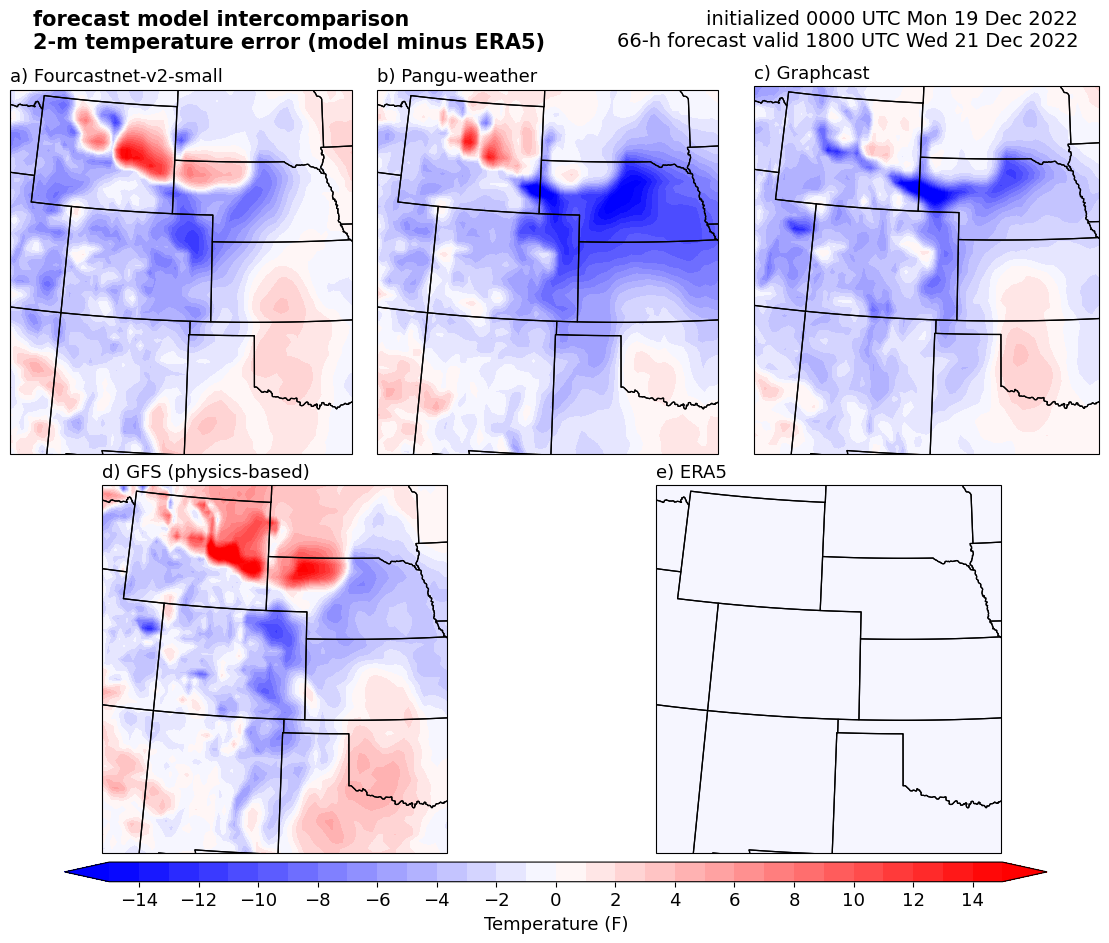

lead: 72
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws
era5


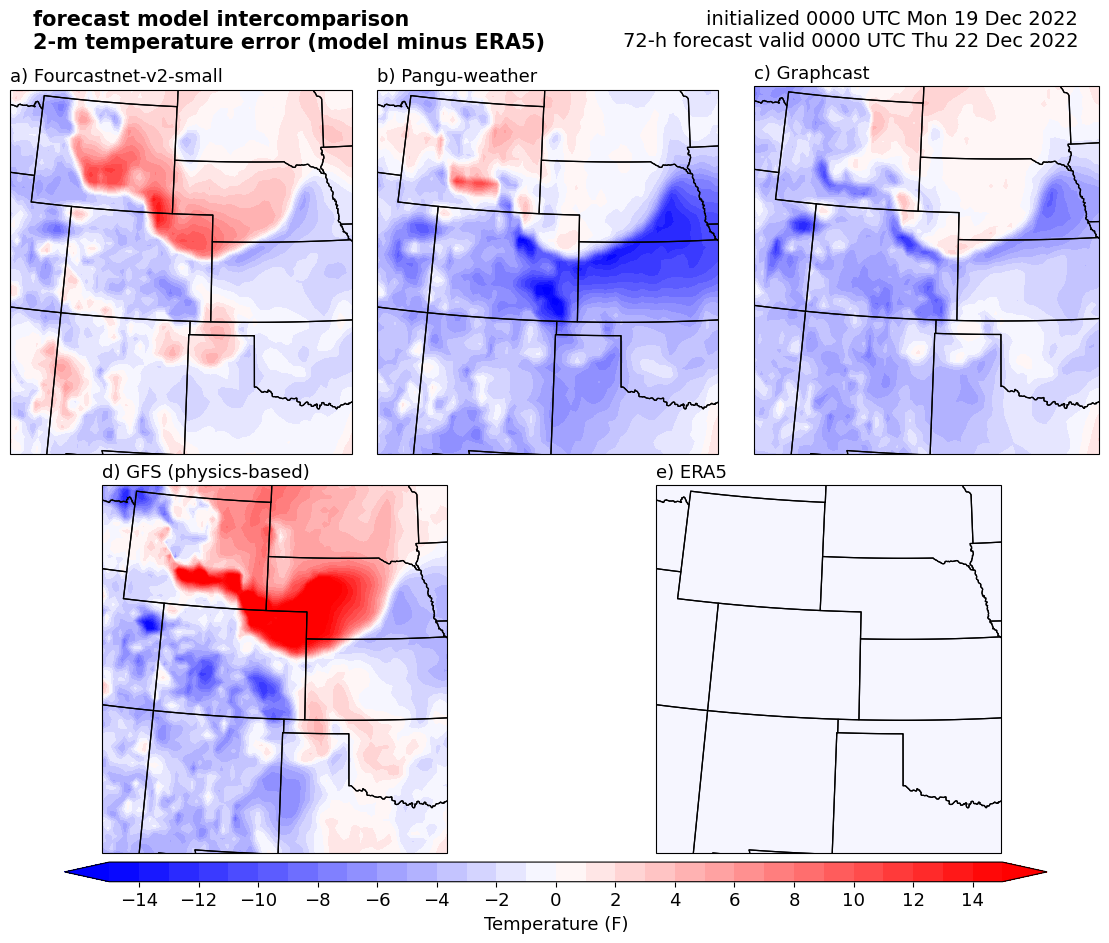

lead: 78
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F78 ┊ GRIB2 @ aws ┊ IDX @ aws
era5


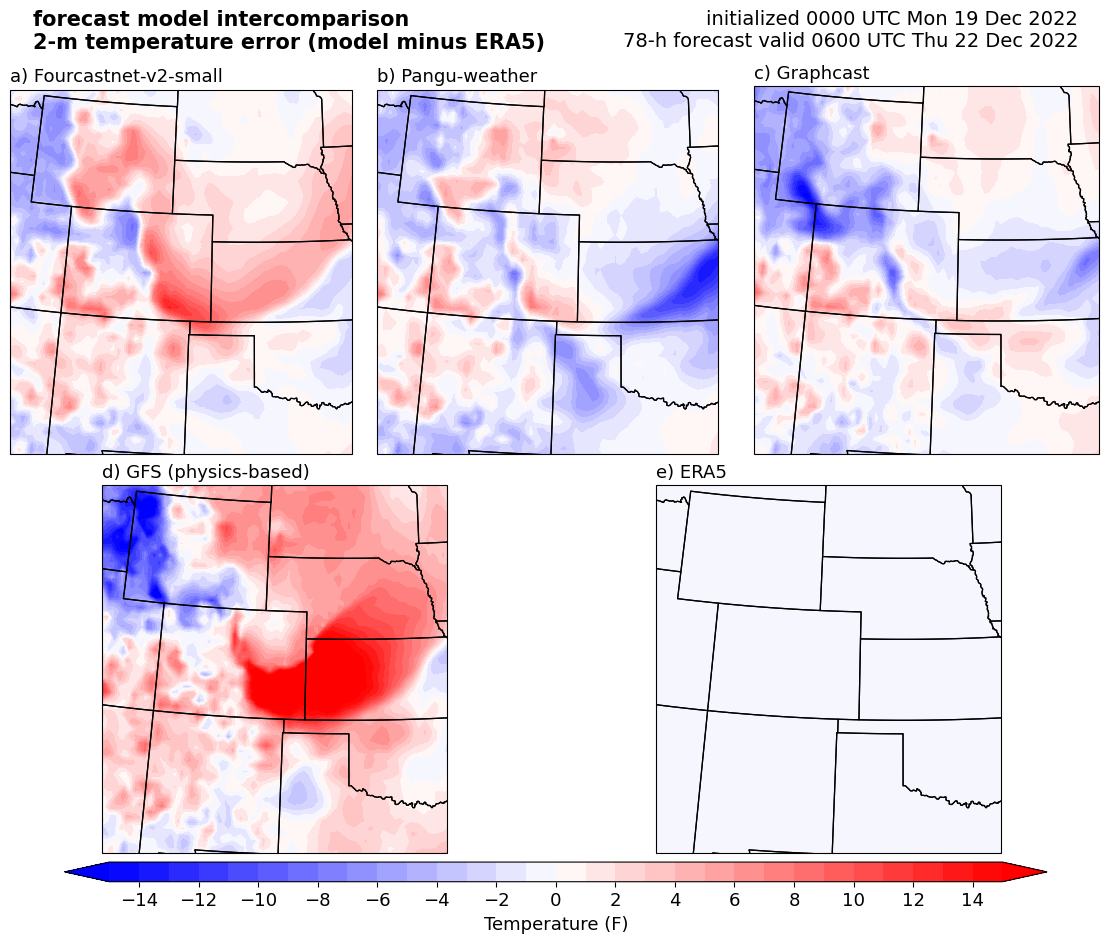

lead: 84
fcn
pangu
gc
gfs
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Dec-19 00:00 UTC F84 ┊ GRIB2 @ aws ┊ IDX @ aws
era5


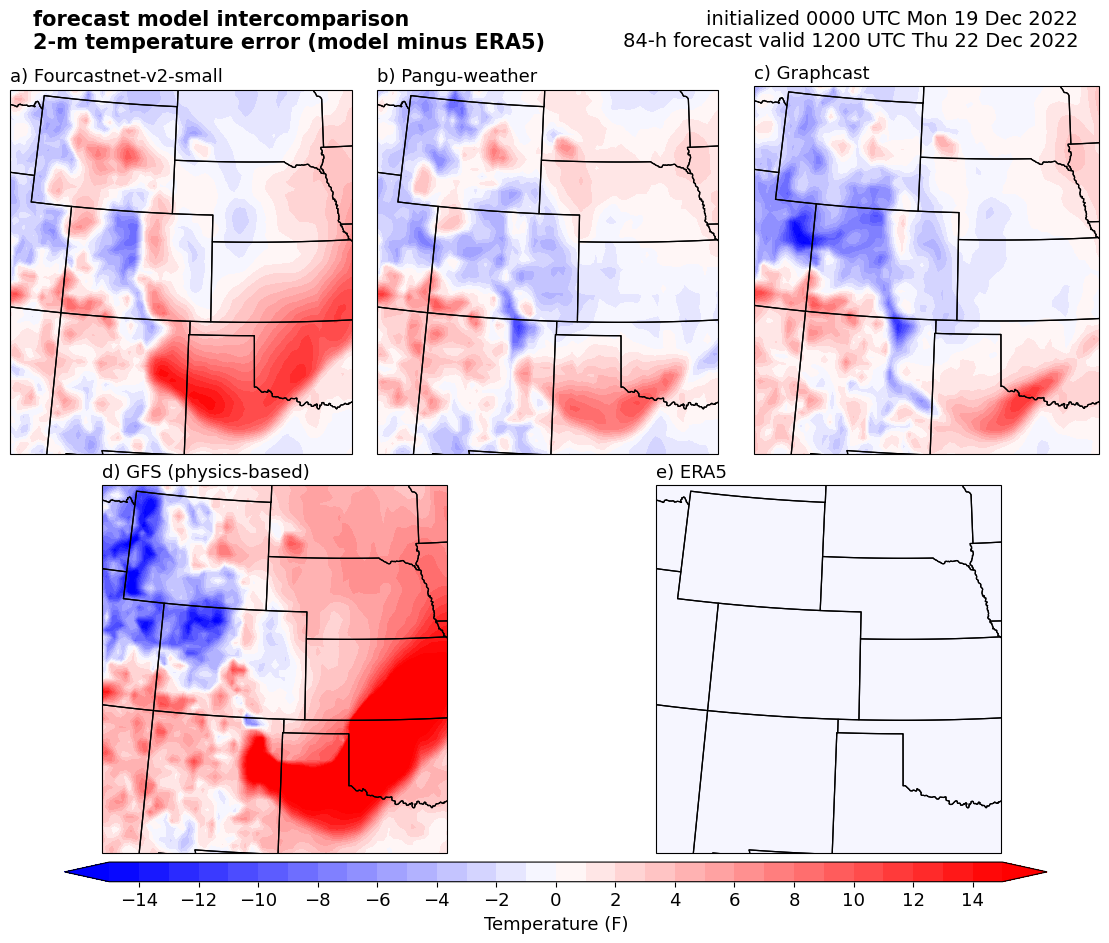

In [35]:
clevs = np.arange(-40, 43, 1)

#fcst_lead = 24
#for fcst_lead in range(0,78,6):
for fcst_lead in leads_to_plot:

    idx = 0

    print("lead: "+str(fcst_lead))

    fig = plt.figure(layout="constrained", figsize=(11,9))

    valid_time = init + pd.Timedelta(hours=fcst_lead)
    
    axlist=[]
    ax_dict = fig.subplot_mosaic(
        [
            #models_to_plot[0:3],
            #models_to_plot[3:6],
            [x for item in models_to_plot[0:3] for x in repeat(item, 2)],
            [x for item in models_to_plot[3:5] for x in repeat(item, 3)]
        ],
        subplot_kw={"projection": plotcrs})
    
    for k, ax in ax_dict.items():
        lonmin, lonmax, latmin, latmax = plot_background(ax)
        axlist = axlist + [ax]

    era5_2m = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-era5-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='')['t2m'].to_dataset()
    
    ### read in data, looping over models
    for model in models_to_plot:
    
        print(model)

        #try:
        if model in ['fcnv2-hres','pangu-hres','aurora-hres','graphcast-hres','fcnv2','aurora','graphcast']:
            ds_2m = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='',
                                    filter_by_keys={'typeOfLevel': 'heightAboveGround', 'level':2})
        elif model in ['ifs','aifs']:
            H = Herbie(init.strftime("%Y-%m-%d %H:%M"), model=model, product="oper", fxx=fcst_lead)
            ds_2m =  H.xarray(":2t:")
        elif model in ['gfs','gfs-graphcast']:
            H = Herbie(init.strftime("%Y-%m-%d %H:%M"), model=model, fxx=fcst_lead)
            ds_2m =  H.xarray(":2 m above ground:", remove_grib=False)
        elif model in ['pangu','fcn','gc']:
            ds_2m = xr.open_dataset("cira_ai_output/"+model+"_t2_subset_"+init.strftime("%Y%m%d%H")+".nc").sel(time=valid_time)['t2'].to_dataset()
            ds_2m = ds_2m.rename({'t2':'t2m'})
        elif model in ['era5']:
            ds_2m = xr.open_dataset("/Users/rschumac/ats780_2024/ai_models/output/"+init.strftime("%Y%m%d%H")+"/output-"+model+"-"+init.strftime("%Y%m%d%H")+"-"+str(fcst_lead)+".grib",
                                     indexpath='')['t2m'].to_dataset()

            
        ### subset data
        if ds_msl.longitude.min().item() >= -10:
            ds_2m = ds_2m.sel(longitude=slice(lonmin+360-5, lonmax+360+5), latitude=slice(latmax+5,latmin-5))
        else:
            ds_2m = ds_2m.sel(longitude=slice(lonmin-5, lonmax+5), latitude=slice(latmax+5,latmin-5))
            
        ### now make the plot! 
        lon2d, lat2d = np.meshgrid(ds_2m.longitude, ds_2m.latitude)
        
        ### 2-m temp
        cf = ax_dict[model].contourf(lon2d, lat2d, ds_2m.t2m-era5_2m.t2m,
                             np.arange(-15,16,1),
                             cmap='bwr', extend='both',
                             transform=ccrs.PlateCarree(), transform_first=True)
        #cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, shrink=0.6)
        #cb.set_label('Temperature (F)', fontsize=10)
        #cb.ax.tick_params(labelsize=10)
        #cb.ax.locator_params(nbins=20)
    
        ax_dict[model].set_title(string.ascii_lowercase[idx]+") "+model_names_dict[model], fontsize=13,
                                loc='left')

        idx = idx + 1
        
   # except:
   #     pass

    ### overall colorbar
    cb = plt.colorbar(cf, ax=axlist, orientation='horizontal', pad=0.01,
                      shrink=0.9, aspect=50)
    cb.ax.tick_params(labelsize=13)
    cb.set_label('Temperature (F)', fontsize=13)
    cb.ax.locator_params(nbins=20)  
    
    ### uses "fig_title" function to make multiple suptitles...
    fig_title(fig, "forecast model intercomparison\n2-m temperature error (model minus ERA5)",
              loc="left", horizontalalignment='left', fontsize=15, fontweight='bold')
    fig_title(fig, "initialized "+init.strftime("%H%M UTC %a %d %b %Y")+"\n"+str(fcst_lead)+"-h forecast valid "+valid_time.strftime("%H%M UTC %a %d %b %Y"),
              loc="right", horizontalalignment='right', fontsize=14)
    
    outdir = imagedir+"/"+init.strftime("%Y%m%d%H")
    os.system("mkdir -p "+outdir)
    
    outfile = "t2m_error_compare_cira_"+init.strftime("%Y%m%d%H")+"_f"+str(fcst_lead).zfill(3)+".png"
    
    plt.savefig(outdir+"/"+outfile,
                bbox_inches='tight', transparent=False, facecolor='white', dpi=225)
    
    plt.show()